# Recapitualzation of Trefethen `p27.m` in python

```
% p27.m - Solve KdV eq. u_t + uu_x + u_xxx = 0 on [-pi,pi] by
%         FFT with integrating factor v = exp(-ik^3t)*u-hat.

% Set up grid and two-soliton initial data:
  N = 256; dt = .4/N^2; x = (2*pi/N)*(-N/2:N/2-1)';
  A = 25; B = 16; clf, drawnow, set(gcf,'renderer','zbuffer')
  u = 3*A^2*sech(.5*(A*(x+2))).^2 + 3*B^2*sech(.5*(B*(x+1))).^2; 
  v = fft(u); k = [0:N/2-1 0 -N/2+1:-1]'; ik3 = 1i*k.^3;

% Solve PDE and plot results:
  tmax = 0.006; nplt = floor((tmax/25)/dt); nmax = round(tmax/dt);
  udata = u; tdata = 0; h = waitbar(0,'please wait...');
  for n = 1:nmax
    t = n*dt; g = -.5i*dt*k;
    E = exp(dt*ik3/2); E2 = E.^2;
    a = g.*fft(real( ifft(     v    ) ).^2);
    b = g.*fft(real( ifft(E.*(v+a/2)) ).^2);     % 4th-order
    c = g.*fft(real( ifft(E.*v + b/2) ).^2);     % Runge-Kutta
    d = g.*fft(real( ifft(E2.*v+E.*c) ).^2);
    v = E2.*v + (E2.*a + 2*E.*(b+c) + d)/6;
    if mod(n,nplt) == 0 
      u = real(ifft(v)); waitbar(n/nmax)
      udata = [udata u]; tdata = [tdata t];
    end
  end
  waterfall(x,tdata,udata'), colormap(1e-6*[1 1 1]); view(-20,25)
  xlabel x, ylabel t, axis([-pi pi 0 tmax 0 2000]), grid off
  set(gca,'ztick',[0 2000]), close(h), pbaspect([1 1 .13])
```

See code:
https://hackmd.io/@NCTUIAM5804/r1sIFj8c8


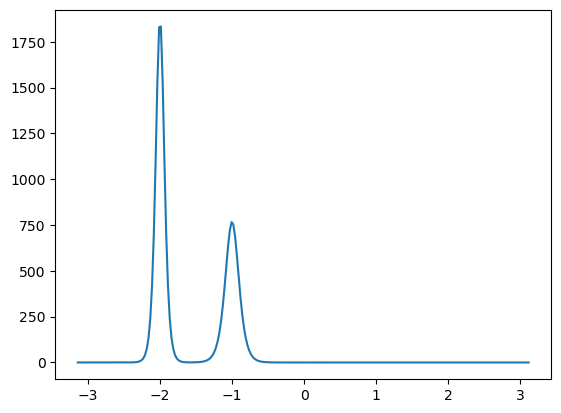

983 6.103515625e-06


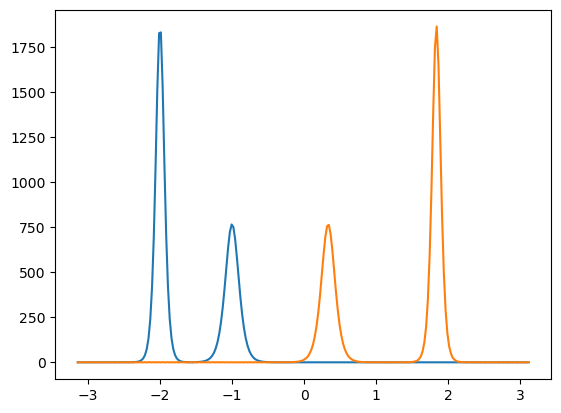

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# gridding
N = 256
dt = 0.4/N**2
x = (2*np.pi/N)*np.arange(-N/2,N/2)
k = np.concatenate((np.arange(N/2) , np.array([0]) , np.arange(-N/2+1,0)))

# IC
A = 25.0
B = 16.0
u = 3.0*(A**2)*(np.cosh(0.5*(A*(x+2))))**(-2) + 3.0*(B**2.0)*(np.cosh(0.5*(B*(x+1))))**(-2)
v = np.fft.fft(u)
ik3 = 1j*k**3

# plot ic
plt.plot(x, u)
plt.show()

# Solve PDE and plot results:

tmax = 0.006; 
nplt = np.floor(tmax/25/dt)
nmax = round(tmax/dt)

udata = [u] 
tdata = [0.0]

print(nmax, dt)

for n in range(1,nmax+1):
    t = n*dt
    g = -0.5j*dt*k
    E = np.exp(dt*ik3/2.0)
    E2 = E**2
    a = g*np.fft.fft((np.fft.ifft(v).real)**2)
    b = g*np.fft.fft((np.fft.ifft(E*(v+a/2)).real)**2)     
    c = g*np.fft.fft((np.fft.ifft(E*v+b/2).real)**2)
    d = g*np.fft.fft((np.fft.ifft(E2*v+E*c).real)**2)
    v = E2*v + (E2*a + 2*E*(b+c) + d)/6 #RK4 update
    if n % nplt == 0: 
      u = np.fft.ifft(v).real
      udata += [u]
      tdata += [t]

# plot initial and final
plt.plot(x,udata[0])
plt.plot(x,udata[-1])
plt.show()

# Explaining program mathematically
The above program in both matlab or python can be separated into two pieces. The first being which creates the necessary input data (gridding, initial conditions, time steps, time step size, etc). The second being the execution of integration of a spectral ODE in time using a 4th order Runge-Kutta iteration. As the exact ODE that is being integrated is not clear (at least not directly from the program) we focus our mathematical explanation here.

## Part 1: setup input data

## Part 2: integrate ODE

### Review of RK4 (4th order Runge-Kutta)
We begin with a brief review of 4th order Runge--Kutta which is an explicit methods to integration ODE which
is 4th order accurate in time. More details are availabe on the [wikipedia page](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

To find a numerical solution to the equation

$$
\dot{u} = f(u,t), \ u(0) = u_0
$$

RK4 proceeds roughly as follows and can be used for $u$ a scalar or a vector.

1. Set $u_0$ as the initial value.
2. For each time step $n$:
   a. Compute the time $t_n = t_0 + nh$.
   b. Compute the four intermediate slopes:
      $$
      \begin{align*}
      k_1 &= hf(u_n, t_n) \\
      k_2 &= hf\left(u_n + \frac{k_1}{2}, t_n + \frac{h}{2}\right) \\
      k_3 &= hf\left(u_n + \frac{k_2}{2}, t_n + \frac{h}{2}\right) \\
      k_4 &= hf\left(u_n + k_3, t_n + h\right)
      \end{align*}
      $$
   c. Compute the weighted average slope:
      $$
      \begin{align*}
      k &= \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)
      \end{align*}
      $$
   d. Update the solution:
      $$
      \begin{align*}
      u_{n+1} &= u_n + k
      \end{align*}
      $$

This procedure approximates the solution of the ODE at each time step $n$ using a weighted average of four slopes.

Let's explore the weights for the spectral ODE for KdV for the general $t_n$ term. We choose $t_0 = 0$ this
provides that $t_n = n\cdot h$. We are actually applying this to $v = \operatorname{fft}(u)$

$$
k_1 &= hf(v_n, t_n) = h \frac{-i k}{2} \exp \left [ \tfrac{ik^3nh}{2} \right ] 
\operatorname{fft}((\operatorname{ifft}(v_n))^2)
$$

Here we note 
